 # [Module 2.5] AutoGluon 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 훈련, 검증 합쳐서 훈련 데이터 생성 (물리적으로 훈련 + 검증)
- AutoGluon 데이터 타입으로 변경
- AutoGluon 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

In [1]:
%store -r train_file
%store -r val_file
%store -r test_file

In [2]:
train_file

'preproc_data/non_feature_engineering/train.csv'

In [3]:
import autogluon.core as ag
from autogluon.tabular import TabularPrediction as task

## 기존 Train, Val을 합쳐서 Train 데이터 생성
오토 글루온은 내부적으로 데이터를 다시 훈련, 검증로 나누어서 사용하기에 입력시에 합쳐서 제공 함

In [4]:
import pandas as pd
from IPython.display import display
import os

def merge_train_val(train_file, val_file, save_file_name):
    train_df = pd.read_csv(train_file)
#     display(train_df.head())
    print('train_df: ', train_df.shape)
    val_df = pd.read_csv(val_file)
#     display(val_df.head())
    print('val_df: ', val_df.shape)    
    train_val_df = pd.concat([train_df, val_df], axis=0)
#     display(train_val_df.head())    
    print('train_val_df: ', train_val_df.shape)   
    train_val_df.to_csv(save_file_name, index=None)
    print(f'{save_file_name} is saved')
    
new_train_val_folder = 'preproc_data/non_feature_engineering/train_val'
os.makedirs(new_train_val_folder, exist_ok=True)
train_val_file_path = os.path.join(new_train_val_folder, 'train_val.csv')
    
merge_train_val(train_file, val_file, train_val_file_path)    

train_df:  (47023, 22)
val_df:  (13435, 22)
train_val_df:  (60458, 22)
preproc_data/non_feature_engineering/train_val/train_val.csv is saved


## 오토글루온 데이터 타입으로 변경

In [5]:
train_data = task.Dataset(file_path=train_val_file_path)
subsample_size = train_data.shape[0]
# subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head())

       classes  customer_zip_code_prefix   customer_city customer_state  \
49649        4                     85760        capanema             PR   
14975        4                     36240   santos dumont             MG   
7275         2                     12312         jacarei             SP   
28089        4                     20725  rio de janeiro             RJ   
22946        4                     21221  rio de janeiro             RJ   

        price  freight_value  product_weight_g  product_length_cm  \
49649   24.99          18.28             237.0               19.0   
14975  129.90          23.84            2600.0               65.0   
7275    27.90           8.36             800.0               26.0   
28089   65.00          16.89            1032.0               17.0   
22946   49.90          17.09            1400.0               43.0   

       product_height_cm  product_width_cm  ...    seller_city  seller_state  \
49649                7.0              15.0  ...      b

In [6]:
label_column = 'classes'
print("Summary of class variable: \n", train_data[label_column].describe())

Summary of class variable: 
 count    60458.000000
mean         2.090890
std          1.152709
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: classes, dtype: float64


## 오토글루운으로 훈련

In [7]:
%%time
dir = 'agModels-predictClass'  # specifies folder where to store trained models
time_limits = 7200 # seconds
# presets = 'best_quality'
presets = 'medium_quality_faster_train'

predictor = task.fit(train_data=train_data, label=label_column, 
                     output_directory=dir,
                     time_limits=time_limits,
                     presets=presets)



Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to agModels-predictClass/
AutoGluon Version:  0.0.15b20201025
Train Data Rows:    60458
Train Data Columns: 21
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [4, 2, 1, 0, 3]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
	Available Memory:                    70253.98 MB
	Train Data (Original)  Memory Usage: 38.81 MB (0.1% of available memory)
	Inferring data type of each feature based on 

CPU times: user 1h 13min 45s, sys: 34min 38s, total: 1h 48min 23s
Wall time: 6min 47s


## 테스트 데이터 로딩

In [8]:
test_data = task.Dataset(file_path=test_file)
y_test = test_data[label_column]  # values to predict
test_data_nolab = test_data.drop(labels=[label_column],axis=1)  # delete label column to prove we're not cheating
print(test_data_nolab.head())

Loaded data from: preproc_data/non_feature_engineering/test.csv | Columns = 22 / 22 | Rows = 6718 -> 6718


   customer_zip_code_prefix        customer_city customer_state   price  \
0                     12951              atibaia             SP   35.00   
1                     64016             teresina             PI   21.99   
2                     37900               passos             MG   69.90   
3                     71510             brasilia             DF  284.90   
4                     12244  sao jose dos campos             SP  129.90   

   freight_value  product_weight_g  product_length_cm  product_height_cm  \
0           8.41             350.0               21.0                9.0   
1          22.85             300.0               17.0                4.0   
2          18.59             125.0               20.0               16.0   
3          18.29             610.0               18.0               12.0   
4          12.30            1700.0               30.0               35.0   

   product_width_cm product_category_name_english  ...           seller_city  \
0           

## 모델 예측

In [9]:
predictor = task.load(dir)  # unnecessary, just demonstrates how to load previously-trained predictor from file

prediction = predictor.predict(test_data_nolab)
print("Predictions:  ", prediction)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.9236379874962787
Evaluations on test data:
{
    "accuracy": 0.9236379874962787,
    "accuracy_score": 0.9236379874962787,
    "balanced_accuracy_score": 0.9062406104248044,
    "matthews_corrcoef": 0.9001446124707135
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.9905660377358491,
        "recall": 0.8320126782884311,
        "f1-score": 0.9043927648578811,
        "support": 631
    },
    "1": {
        "precision": 0.9187784275503573,
        "recall": 0.9259986902423052,
        "f1-score": 0.9223744292237444,
        "support": 1527
    },
    "2": {
        "precision": 0.909369527145359,
        "recall": 0.9664960446719404,
        "f1-score": 0.9370629370629371,
        "support": 2149
    },
    "3": {
        "precision": 0.9260897030953885,
        "recall": 0.9173967459324155,
        "f1-score": 0.921722728701666,
        "support": 1598
    },
    "4": {
        "precision": 0.9245524296675192,
    

Predictions:   [1 3 3 ... 1 4 0]


## 리더 보드 생성

In [10]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,weighted_ensemble_k0_l1,0.923638,0.9428,5.514165,2.380832,355.301801,0.099967,0.000871,0.553791,1,True,12
1,NeuralNetClassifier,0.916195,0.9380,5.143605,2.244307,311.558030,5.143605,2.244307,311.558030,0,True,1
2,CatboostClassifier,0.889253,0.8924,0.084352,0.066445,36.333700,0.084352,0.066445,36.333700,0,True,10
3,LightGBMClassifierCustom,0.884192,0.8892,0.157537,0.056854,8.840547,0.157537,0.056854,8.840547,0,True,11
4,LightGBMClassifier,0.873325,0.8804,0.186241,0.069209,6.856280,0.186241,0.069209,6.856280,0,True,8
5,RandomForestClassifierEntr,0.660613,0.6512,1.155991,0.114755,4.790672,1.155991,0.114755,4.790672,0,True,5
6,RandomForestClassifierGini,0.655403,0.6488,0.971993,0.116232,2.579347,0.971993,0.116232,2.579347,0,True,4
7,LightGBMClassifierXT,0.647216,0.6464,0.155905,0.059449,4.849348,0.155905,0.059449,4.849348,0,True,9
8,ExtraTreesClassifierEntr,0.489283,0.4732,3.368678,0.114109,2.077636,3.368678,0.114109,2.077636,0,True,7
9,ExtraTreesClassifierGini,0.483924,0.4796,2.398932,0.113786,1.621541,2.398932,0.113786,1.621541,0,True,6


## 모델 평가

In [11]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.92%
f1_score: 0.92%


[[ 525  101    5    0    0]
 [   3 1414  108    2    0]
 [   2   23 2077   43    4]
 [   0    1   76 1466   55]
 [   0    0   18   72  723]]


<Figure size 432x288 with 0 Axes>

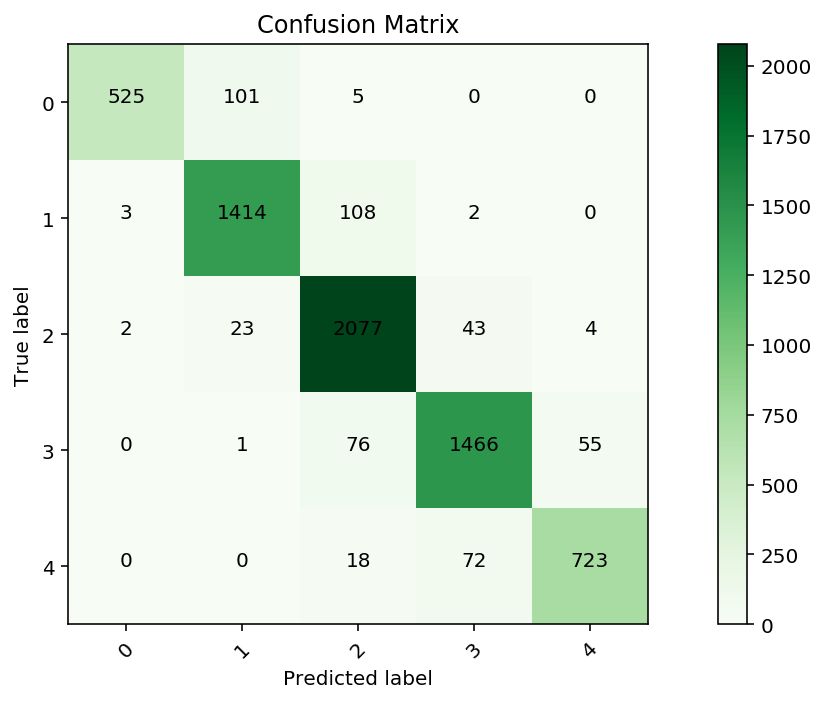

In [12]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

Computing raw permutation importance for 21 features on weighted_ensemble_k0_l1 ...
	28.91s	= Expected runtime
	28.36s	= Actual runtime


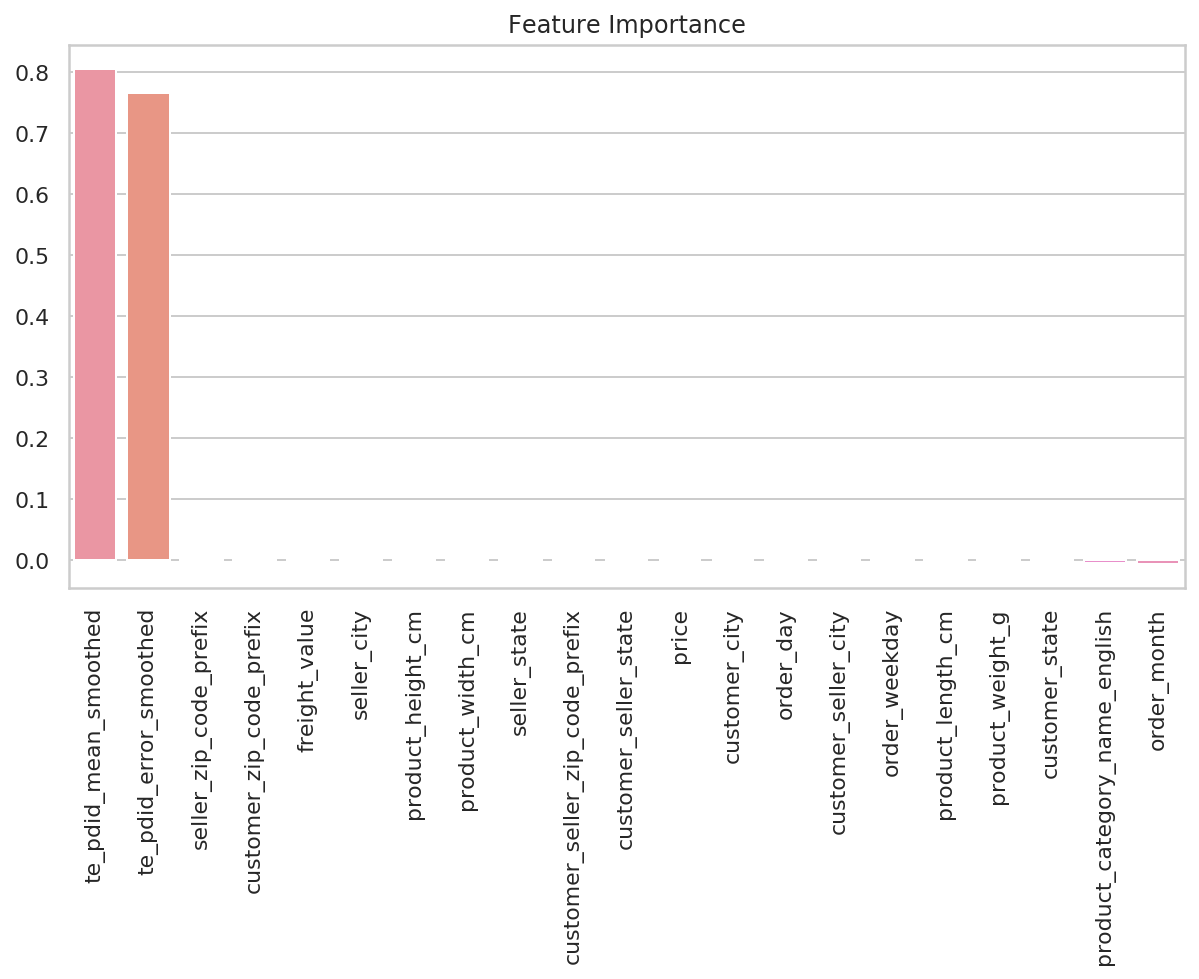

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance = predictor.feature_importance(test_data)

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_importance.index, y = fea_importance.values)
# plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()